In [67]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6_200121_v0"
cut = "lowen_looseVBS"

In [3]:
os.listdir(os.path.join(samples_dir, cut))

['DY_part1.pkl',
 'DY_part2.pkl',
 'DY_part3.pkl',
 'VBS_part1.pkl',
 'Wjets_part1.pkl',
 'background_part1.pkl',
 'top_part1.pkl']

In [4]:
samples = {}
for sname in ["VBS", "background"]:
    files = [f for f in os.listdir(os.path.join(samples_dir, cut)) if sname in f]
    for file in files:
        s = pickle.load(open(os.path.join(samples_dir, cut, file), "rb"))
        sname = file.split("_part")[0]
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
        s["sample"]= sname

        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s


In [5]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.XSWeight*df.weight*df.puWeight).sum()*41:15}")

Sample name VBS       , nsamples:     123434,   XS total: 542.991743729673
Sample name background, nsamples:     522170,   XS total: 177007.07816240547


In [93]:
samples["VBS"].columns

Index(['weight', 'XSWeight', 'Lepton_RecoSF', 'LepWPWeight', 'puWeight',
       'TriggerEffWeight_1l', 'btagSF', 'PrefireWeight', 'events', 'Lepton_pt',
       'Lepton_eta', 'Lepton_phi', 'Lepton_flavour', 'PuppiMET',
       'PuppiMET_phi', 'MET_pt', 'recoMET_pz', 'nJets', 'N_jets_central',
       'N_jets_forward', 'mjj_vbs', 'deltaeta_vbs', 'deltaphi_vbs',
       'vbs_etaprod', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta',
       'vbs_0_phi', 'vbs_1_phi', 'vbs_index_0', 'vbs_index_1', 'mjj_vjet',
       'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'vjet_0_phi',
       'vjet_1_phi', 'vjet_index_0', 'vjet_index_1', 'Zvjets_0', 'Zlep',
       'Asym_vbs', 'Asym_vjet', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww',
       'R_ww', 'R_mw', 'A_ww', 'Centr_vbs', 'Centr_ww', 'nvtx', 'qgl',
       'sample'],
      dtype='object')

## Samples preparation for NN

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


In [7]:
cols = ["mjj_vbs", "mjj_vjet", "deltaeta_vbs", "vbs_0_pt", "vbs_1_pt", "vbs_0_eta", "vbs_1_eta", "Lepton_pt", "Lepton_eta", "Lepton_flavour"]
weights = ["btagSF", "Lepton_Reco"]

In [38]:
X_sig = samples["VBS"][cols].values
X_bkg = samples["background"][cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))

Stack arrays in one only ntuple

In [39]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{samples_dir}/{cut}/models/scaler_model_v0.pkl", "wb"))

In [62]:
den=True

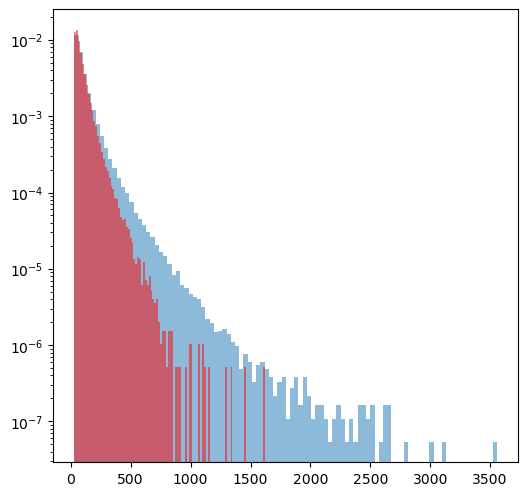

In [71]:
_ = plt.hist(X[Y==0][:,7], bins=100, density=den, alpha=0.5)
_ = plt.hist(X[Y==1][:,7], bins=100, color="r", density=den, alpha=0.5)
plt.yscale("log")
#plt.scatter(X_scaled[Y==1][:,4], X_scaled[Y==1][:,1], c="b")

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

Create generators to balance signal and background

In [76]:
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train,  batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [87]:
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation="relu"))
#model.add(Dropout(0.3))
#model.add(Dense(80, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 3,151
Trainable params: 3,151
Non-trainable params: 0
_________________________________________________________________


In [88]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=50,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [early_stop]
            )

Epoch 1/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5527 - acc: 0.7068 - val_loss: 0.5420 - val_acc: 0.7151
Epoch 2/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5408 - acc: 0.7167 - val_loss: 0.5403 - val_acc: 0.7178
Epoch 3/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5394 - acc: 0.7177 - val_loss: 0.5397 - val_acc: 0.7184
Epoch 4/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5387 - acc: 0.7181 - val_loss: 0.5395 - val_acc: 0.7188
Epoch 5/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5382 - acc: 0.7185 - val_loss: 0.5391 - val_acc: 0.7194
Epoch 6/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5379 - acc: 0.7186 - val_loss: 0.5390 - val_acc: 0.7191
Epoch 7/50
764/764 [==============================] - 2s 3ms/step - loss: 0.5377 - acc: 0.7189 - val_loss: 0.5391 - val_acc: 0.7187
Epoch 8/50
764/764 [==============================] - 2s 3ms/step - loss: 0.

In [89]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
fp, tp, th = roc_curve(y_test, pred)
print("AUC score: " + str(auc))

>>> Computing AUC...
AUC score: 0.8017602987021


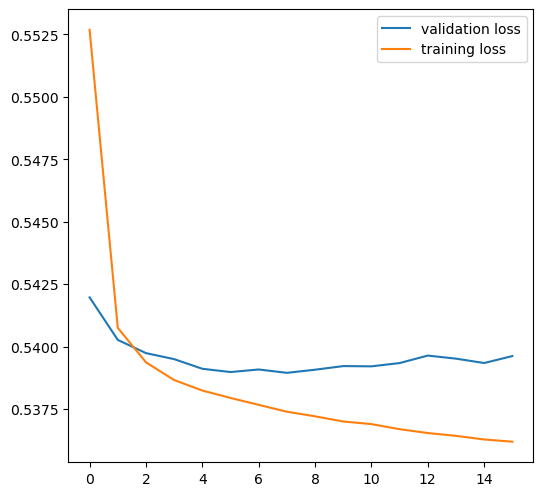

In [90]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

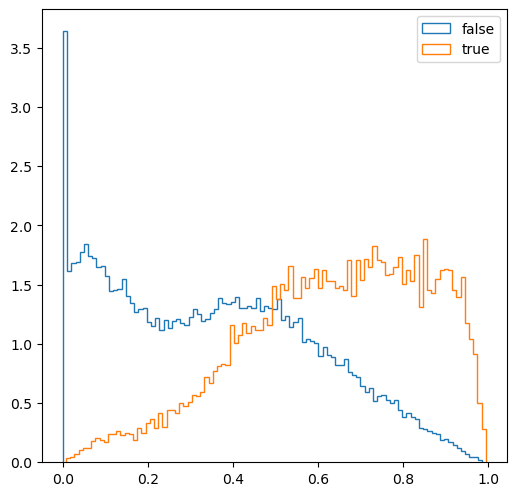

In [91]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

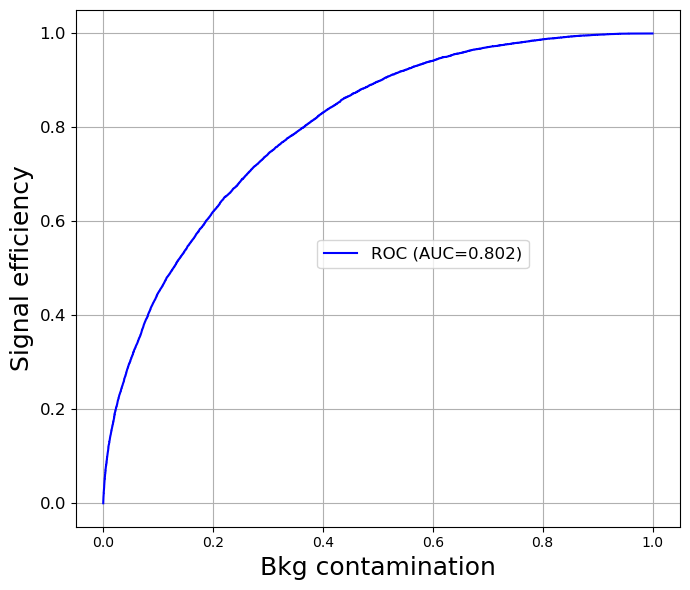

In [92]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()